#Modeling Concessions Across Multi-Family Buildings in the United States

##Section I. Data Set

The dataset composes of internal and external sources of data. Internal sources of data comprise of proplist.txt and listtrend.txt provided by Axiometrics. It was derived from a monthly survey of ~20k properties in the United States from 2008 to 2015, in which property owners were asked about the properties. External sources of data comprise of economic indicators provided by Moody Data Buffet and Supply of Multi-Family provided by Axiometrics.

##Section II. Description of Variables

The dataset contains 63710 observations of 15 dependent variables and 1 independent variable.  

*Proplist.txt and Listtrend.txt from Axiometrics
1. Quantity: Number of units in a building
2. Level: Number of floors in a building
3. AreaPerUnit: Average amount of area (sq. feet) in a unit
4. Age: Age of the building (date of observation - Year Built)
5. Renovation Age: Age of the building since the last renvoation (date of observation - date of last renovation or construction)
6. ConcessionPct: % of Concession $\frac{Asking Rent - Expected Rent}{Asking Rent}$
7. AskingRentChange: Monthly %change in Asking Rent
8. AskingRentChange_year: Annual %change in Asking Rent

*Moody Data Buffet and Axiometrics
8. New Supply: Monthly %change in the supply of new Multi-Family Buildings
9. YoungAgeGroup: Monthly %change in the population segment age of 25-44
10. LaborForceParticipation: A measure of the active portion of an economy's labor force in %
11. HomePriceIndex: Monthly %change in the Home Price Index with 1995Q1=100
12. UR: Unemployment Rate 
13. YoungAgeGroup_year: Annual %change in the population segment age of 25-44
14. LaborForceParticipation_year: Annual %change in the active portion of an economy's labor force in %
15. HomePriceIndex_year: Annual %change in the Home Price Index with 1995Q1=100

##Section III. Problem Statement

Expected Rent or Concession of a property is often not given. This statistics is more useful than the given asking rent to calculate each property's cash flow. Thus, this paper wants to infer the concession % in relative to the asking rent from the given characteristics about the property and underlying economic conditions. 

##Section IV. Data Pre-Processing

###1.  Importing libraries and packages

In [2]:
import numpy as np
import scipy as sp
#panda for data reading csv
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt  
import csv
import array
import requests
import StringIO
import zipfile
import scipy.stats 
from collections import OrderedDict
from datetime import datetime
import operator
import statsmodels.api as sm
import seaborn as sns
import math
#patsy is a module for describing data
#sklearn is a useful tool for machine learning
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn import linear_model
import random

###2. Reading in CSVs and prepping them for analysis
##### *Shown below is some of the process done to consolidate the data together. To facilitate the process for future use and clear up the memory, data was periodically exported out to csv. The final data the file works with is called "TEST". Below operations can be skimmed.

In [3]:
#Function to read in csv files
%matplotlib inline  
def csvConvert(file):
    result = []
    csvfile = open(file, 'rb')
    table = csv.reader(csvfile)
    for row in table:                   #Goes to each row in CSV
        result.append([])
        for i in range(0,len(row)):     #Goes to each element in row
            if row[i]=='':
                result[len(result)-1].append('N/A') #Null element transformed to Not Applicable
            else:
                result[len(result)-1].append(row[i])   #Element added
#    return result 

csvConvert('small.csv')
csvConvert('big.csv')

In [4]:
##import supply of Multifamily
csvConvert('testaxiometrics.csv')
testaxiometrics = pd.read_csv(open('testaxiometrics.csv'))

In [6]:
##import asking age and renovationage in years
csvConvert('ageofbuildings.csv')
ageofbuildings = pd.read_csv(open('ageofbuildings.csv'))

csvConvert('renovationbuildings.csv')
renovationbuildings = pd.read_csv(open('renovationbuildings.csv'))

In [16]:
#importing change in askingrent by months
csvConvert('askingchange.csv')
askingchange = pd.read_csv(open('askingchange.csv'))

In [9]:
#importing data file (which is from Moody with Monthly change) and axiometrics file with supply of MF
#Moody monthly data of economic indicators such as Unemployment Rate
data = pd.read_csv(open('data.csv'))
axiometrics = pd.read_csv(open('axiometrics.csv'))

#this changes the dtype of values in Month column to datetime for consistency
data['Month']=pd.to_datetime(data['Month'])

In [19]:
#In a dataset with supply of MF, selecting for Atlanta properties
#Selecting only month, existing supply of MF, and the change
#Reset the index to make it easy to iterate for future use

axiometrics = axiometrics[axiometrics.MetroID == 12060]
axiometrics = axiometrics[['Month','Existing','New Supply']]
axiometrics = axiometrics.reset_index(drop=True)

In [109]:
#small.csv is the data with ~20k properties nationwide
#big.csv is the temporal data for the aforementioned data from 2008 to 2015 monthly
#atlanta is getting the subset from the smaller dataset by looking for its specific MSA code
srent = pd.read_csv(open('small.csv'))
brent = pd.read_csv(open('big.csv'))
atlanta = srent[srent.Msa_Code == 12060]

#this changes the dtype of values in Month column to datetime for consistency
#we are adding 01 to make python better recognize it into datetime format
brent.Month="01-"+ brent.Month
brent['Month']=pd.to_datetime(brent['Month'])

In [170]:
#Merging temporal data for the list of properties in Atlanta
#Selecting certain columns from the joined list
#Sorting the list by Months

joined = pd.merge(atlanta, brent, how="inner", on=['ProjID'])
joined = joined[['ProjID','Month','Msa_Code','YearBuit','Rehab1','Rehab2','Rehab3','Quantity','AreaPerUnit','ConcessionPct','Level','AskingRent']]
joined=joined.sort(columns="Month")

In [20]:
#Getting the Moody monthly data for a certain time period and resetting the index
data = data[data.Month > '2008-03-01']
data = data[data.Month < '2015-04-01']
data = data.reset_index(drop=True)

#selecting for these columns only
data = data[['Month','Ages 25-44','MFStart','Labor Force Participation','Home Price Index', 'UR']]

#renaming the columns names because Python is not friendly with space in the column name
data.columns = ['Month','YoungAgeGroup','MFStart','LaborForceParticipation','HomePriceIndex', 'UR']

In [67]:
#joining concessions data with Moody monthly data
joinedwithmoody = pd.merge(concessionpct, data, how="inner", on=['Month'])

In [129]:
#testaxiometrics is the dataframe for Supply change in MF
#Renaming the column name because spaces don't work very well
testaxiometrics.columns=['Month','Existing','NewSupply']

#convert the month into datetime and remove the time component
testaxiometrics['Month']=pd.to_datetime(testaxiometrics['Month'])

In [ ]:
#chaging the format of dates in testaxiometrics
for i in range (0, len(testaxiometrics)):
    testaxiometrics.Month[i]=datetime.strptime(testaxiometrics.Month[i], '%Y-%d-%m').strftime('%Y-%m-%d')

In [145]:
#merge with joinedwithmoody
joinedwithsupply = pd.merge(joinedwithmoody, testaxiometrics, how="inner", on=['Month'])

In [183]:
#convert the month into datetime and remove the time component
asking['Month']=pd.to_datetime(asking['Month'])
ageofbuildings['Month']=pd.to_datetime(ageofbuildings['Month'])
renovationbuildings['Month']=pd.to_datetime(renovationbuildings['Month'])

C:\Users\NBA507\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [190]:
#Joining age of the buildings with building data=joinedwithage
joinedwithage = pd.merge(joined, ageofbuildings, how="inner", on=['ProjID','Month'])

#Joining joinedwithage with renovation age
joinedwithrenovation = pd.merge(joinedwithage, renovationbuildings, how="inner", on=['ProjID','Month'])

#Joining the supply of MF  testaxiometrics
joinedwithsupply = pd.merge(joinedwithrenovation, testaxiometrics, how="inner", on=['Month'])

#Joining with Moody monthly data of economic indicators
joinedwithdata = pd.merge(joinedwithsupply, data, how="inner", on=['Month'])

#Joining with monthly change in Asking rent
joinedwithasking = pd.merge(joinedwithdata, askingchange, how="inner", on=['ProjID', 'Month'])

In [41]:
#Saving this file as CSV in case the file gets messed up
joinedwithasking.to_csv("joinedwithasking.csv")

In [9]:
#reading in the CSV file to start from here
csvConvert('joinedwithasking.csv')
joinedwithasking = pd.read_csv(open('joinedwithasking.csv'))
#whenever importing an updated csv, make sure to change datetime
joinedwithasking['Month']=pd.to_datetime(joinedwithasking['Month'])

In [10]:
#Moody Data with year% change
csvConvert('yearchangedata.csv')
yearchangedata = pd.read_csv(open('yearchangedata.csv'))

#Changing the dtype of values in Month column to datetime for consistency
yearchangedata['Month']=pd.to_datetime(yearchangedata['Month'])

####Downloading AskingRentChange% by year, converting to datetime
csvConvert('askyearchange.csv')
askyearchange = pd.read_csv(open('askyearchange.csv'))
askyearchange['Month']=pd.to_datetime(askyearchange['Month'])

#Changing the column names 
yearchangedata.columns=['Month','YoungAgeGroup_year','LaborForceParticipation_year','UR', 'HomePriceIndex_year']
yearchangedata=yearchangedata[['Month','YoungAgeGroup_year','LaborForceParticipation_year', 'HomePriceIndex_year']]

#Joining year% change data of Moody
joinedwithyearchange = pd.merge(joinedwithasking, yearchangedata, how="inner", on=['Month'])

#Joining with asking rent change % by year
TEST = pd.merge(joinedwithyearchange, askyearchange, how="inner", on=['ProjID', 'Month'])

#In the AskingRentChange_year column
#Entry 'hi' represents N/A when the data entries are younger than a year to track change by year to year
#The dataset thus excludes rows with this entry and resets the index

TEST=TEST[TEST.AskingRentChange_year != 'hi']
TEST = TEST.reset_index(drop=True)

#change dtype of askingrentyear% from object to float
TEST = TEST.convert_objects(convert_numeric=True)

#Gettting rid of positive concessions (expected rent > asking rent) and converting them to positive for easy read
TEST=TEST[TEST.ConcessionPct<=0]
TEST.ConcessionPct=abs(TEST.ConcessionPct)

##Section V. Data Exploration: Selection and Cleaning

Data Selection means methods to select variables that might be pertinent towards concession%. Single factor analysis was performed on the interal source of data. Variables that showed relevant patterns with the concession% were selected. 

Data Cleaning means methods to clean out outliers and variables that don't particularly don't help predict concession%. 

In [ ]:
bytreatment = joined.groupby('Month')
concession1=joined['ConcessionPct'].mean()


bytreatment = joined.groupby(['Month'], as_index=False).mean()
bytreatment

In [126]:
PropertyTEST=TEST[['ProjID','YearBuit','Quantity','AreaPerUnit', 'AskingRentChange', 'Level', 'AskingRent_x', 'HomePriceIndex', 'UR', 'age', 'RenovationAge', 'LaborForceParticipation','NewSupply','YoungAgeGroup','binaryConcession', 'YoungAgeGroup_year', 'LaborForceParticipation_year', 'HomePriceIndex_year', 'AskingRentChange_year', 'PredictedConcession', 'LinearPredictedConcession','ConcessionPct']]

PropertyTEST = PropertyTEST.groupby(['ProjID'], as_index=False).mean()
PropertyTEST['binaryConcession'] = (PropertyTEST.ConcessionPct > 0).astype(int)

PropertyTEST.groupby('binaryConcession').mean()

,ProjID,YearBuit,Quantity,AreaPerUnit,AskingRentChange,Level,AskingRent_x,HomePriceIndex,UR,age,...,LaborForceParticipation,NewSupply,YoungAgeGroup,YoungAgeGroup_year,LaborForceParticipation_year,HomePriceIndex_year,AskingRentChange_year,PredictedConcession,LinearPredictedConcession,ConcessionPct
binaryConcession,,,,,,,,,,,,,,,,,,,,,
0,31092.102041,1994.755102,203.183673,1084.703358,0.004207,4.040816,1069.973791,0.447223,7.130836,19.199865,...,65.699814,0.001235,0.068548,0.739880,-0.832024,5.226308,0.034082,-0.018950,-0.017005,0.000000
1,16633.856151,1990.519841,279.178571,1036.674262,0.002132,3.266865,899.049385,0.060593,8.427617,22.012768,...,66.657758,0.000775,0.024524,0.122632,-1.266797,0.258923,0.013517,-0.054361,-0.053427,0.055902


#Section VII: Linear Regression

##1. Doing OLS using OLS package from Statsmodels

In [11]:
#importing package to regress
import statsmodels.formula.api as smf

In [12]:
#Performing OLS
lm = smf.ols(formula='ConcessionPct ~ Quantity + Level + AreaPerUnit + age + RenovationAge + NewSupply + YoungAgeGroup + LaborForceParticipation + HomePriceIndex + UR + AskingRentChange+YoungAgeGroup_year+LaborForceParticipation_year+HomePriceIndex_year + AskingRentChange_year', data=TEST).fit()
#Print out a summary from the linear regression
lm.summary()
#bigger t-statistics in absolute value term, stronger. it's coef/SE

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ConcessionPct   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     1276.
Date:                Wed, 22 Jul 2015   Prob (F-statistic):               0.00
Time:                        10:03:51   Log-Likelihood:                 75127.
No. Observations:               63710   AIC:                        -1.502e+05
Df Residuals:                   63694   BIC:                        -1.501e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
Intercept                       -0.3319      0.107     -3.099      0.002        -0.542    -0.122
Quantity                      3.856e-06   2.01e-06      1.921      0.055     -7.77e-08  7.79e-06
Level                           -0.0016      0.000     -9.795      0.000        -0.002    -0.001
AreaPerUnit                  -1.941e-06   1.91e-06     -1.015      0.310     -5.69e-06  1.81e-06
age                              0.0009   3.68e-05     23.156      0.000         0.001     0.001
RenovationAge                    0.0001   3.85e-05      2.679      0.007      2.77e-05     0.000
NewSupply                       14.3297      1.186     12.082      0.000        12.005    16.654
YoungAgeGroup                    0.0165      0.026      0.631      0.528        -0.035     0.068
LaborForceParticipation          0.0031      0.002      1.767      0.077        -0.000     0.007
HomePriceIndex                  -0.0029      0.001     -4.945      0.000        -0.004    -0.002
UR                               0.0173      0.002      9.569      0.000         0.014     0.021
AskingRentChange                 0.0442      0.007      5.893      0.000         0.029     0.059
YoungAgeGroup_year              -0.0123      0.002     -5.875      0.000        -0.016    -0.008
LaborForceParticipation_year    -0.0033      0.000     -7.628      0.000        -0.004    -0.002
HomePriceIndex_year             -0.0013      0.000     -5.284      0.000        -0.002    -0.001
AskingRentChange_year            0.1238      0.004     34.681      0.000         0.117     0.131
==============================================================================
Omnibus:                     9070.880   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14079.207
Skew:                           1.011   Prob(JB):                         0.00
Kurtosis:                       4.102   Cond. No.                     4.39e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.39e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [193]:
#A quick function to predict the concessio% based on the input values
def linearpredict(quantity, level, areaperunit, age, renovationage, newsupply, youngagegroup, laborforceparticipation, homepriceindex, UR, AskingRentChange):
    X_new = pd.DataFrame({'Quantity': [quantity], 'Level': [level], 'AreaPerUnit': [areaperunit], 'age': [age], 'RenovationAge': [renovationage], 'NewSupply': [newsupply], 'YoungAgeGroup': [youngagegroup], 'LaborForceParticipation': [laborforceparticipation], 'HomePriceIndex': [homepriceindex], 'UR': [UR], 'AskingRentChange': [AskingRentChange]})
    X_new.head()
    print lm.predict(X_new)

In [28]:
#testing with the entry 78108
#supposed to be 0. overestimates
linearpredict(138, 3 , 856.057971, 22.175342, 22.175342, 0.001662, 0.089969, 65.052672, 0.625136, 5.955253, 0)

[ 0.00553222]


In [27]:
#testing with the entry 78107
#supposed to be -0.044. overestimated
linearpredict(220,3,1081.636364,47.194521,47.194521,0.001662,0.089969,65.052672,0.625136,5.955253,0.013061)

[-0.01695794]


## 2. Polynomial Regression

In [13]:
#Each variable was added one by one to see what effect it would have on R^2
poly_3 = smf.ols(formula='ConcessionPct ~ Quantity + I(Quantity ** 2.0) + I(Quantity ** 3) + Level +I(Level ** 2.0)+ AreaPerUnit + age+I(age ** 2.0)+I(age ** 3.0) + RenovationAge+I(RenovationAge ** 2.0) +I(RenovationAge ** 3.0) + NewSupply + YoungAgeGroup + I(YoungAgeGroup ** 2.0) + LaborForceParticipation + UR + I(UR ** 2)+ AskingRentChange +I(AskingRentChange ** 2.0) + +I(AskingRentChange ** 3.0)+YoungAgeGroup_year+LaborForceParticipation_year+HomePriceIndex_year+ AskingRentChange_year', data=TEST).fit()
poly_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ConcessionPct   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     860.7
Date:                Wed, 22 Jul 2015   Prob (F-statistic):               0.00
Time:                        10:03:54   Log-Likelihood:                 76032.
No. Observations:               63710   AIC:                        -1.520e+05
Df Residuals:                   63684   BIC:                        -1.518e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
Intercept                       -0.1692      0.107     -1.584      0.113        -0.379     0.040
Quantity                      7.147e-05   9.59e-06      7.449      0.000      5.27e-05  9.03e-05
I(Quantity ** 2.0)           -9.394e-08   1.81e-08     -5.180      0.000     -1.29e-07 -5.84e-08
I(Quantity ** 3)              2.157e-11   8.31e-12      2.597      0.009      5.29e-12  3.78e-11
Level                           -0.0032      0.000     -7.853      0.000        -0.004    -0.002
I(Level ** 2.0)               5.781e-05    1.4e-05      4.137      0.000      3.04e-05  8.52e-05
AreaPerUnit                  -6.117e-06    1.9e-06     -3.218      0.001     -9.84e-06 -2.39e-06
age                             -0.0015      0.000     -6.079      0.000        -0.002    -0.001
I(age ** 2.0)                 8.297e-05   7.59e-06     10.939      0.000      6.81e-05  9.78e-05
I(age ** 3.0)                -7.767e-07   6.07e-08    -12.795      0.000     -8.96e-07 -6.58e-07
RenovationAge                   -0.0024      0.000    -10.638      0.000        -0.003    -0.002
I(RenovationAge ** 2.0)          0.0001   9.54e-06     13.920      0.000         0.000     0.000
I(RenovationAge ** 3.0)      -1.891e-06   1.19e-07    -15.906      0.000     -2.12e-06 -1.66e-06
NewSupply                       -0.7937      1.360     -0.583      0.560        -3.460     1.872
YoungAgeGroup                   -0.0583      0.025     -2.298      0.022        -0.108    -0.009
I(YoungAgeGroup ** 2.0)          0.8560      0.140      6.128      0.000         0.582     1.130
LaborForceParticipation          0.0056      0.002      3.176      0.001         0.002     0.009
UR                              -0.0493      0.005    -10.454      0.000        -0.059    -0.040
I(UR ** 2)                       0.0037      0.000     14.369      0.000         0.003     0.004
AskingRentChange                -0.0595      0.009     -6.616      0.000        -0.077    -0.042
I(AskingRentChange ** 2.0)      -0.7418      0.046    -16.227      0.000        -0.831    -0.652
I(AskingRentChange ** 3.0)       4.0330      0.180     22.432      0.000         3.681     4.385
YoungAgeGroup_year              -0.0112      0.002     -5.741      0.000        -0.015    -0.007
LaborForceParticipation_year    -0.0032      0.000     -7.386      0.000        -0.004    -0.002
HomePriceIndex_year             -0.0009      0.000     -3.687      0.000        -0.001    -0.000
AskingRentChange_year            0.1200      0.004     33.913      0.000         0.113     0.127
==============================================================================
Omnibus:                     8971.413   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14049.445
Skew:                           0

##3. Analysis

#####1. Compute F-Statistic and examine the associated p-value. Here F-Statistic is 909.6 and its p-value is 0. 
It shows that at least one of the predictors are useful in predicting the response. 
In a simlple linear regression setting, in order to determine whether there is a relationship between the response and the predictor, we check whether the coefficient $\beta_1=0$.

In a multiple linear regression setting, in order to determine whether there is a relationship between the response and the predictor, we check whether all of the coefficient $\beta_1=\beta_2=\dots=\beta_p=0$. This becomes our null hypothesis.

F-Statistics tests this hypothesis. When there is no relationship between the response and predictors, F-statistic would take a value close to 1. 909.6 is much bigger than 1, so it provides compelling evidence against the null hypothesis. Large F-Statisc suggests at least one of the variables must be related to concession%. Its associated p-value (=0) confirms this. 

Using F-Statistics to test for any association between the predictors and the response works when p "number of variables" is relatively small compared to n. (21 < 65000).

####2. Deciding on Important Variables-Variable Selection
Looking at p-value could lead to false conclusions. Since this is using 95% CI, 5% of the p-values associated with each varaible will be below 0.05 by chance.  

1. Forward Selection: being with null model with only intercept, and fit p simple regresesions. Then add to the model that has lowest RSS.

2. Backward Selection: Start with everything, remove the variable with the largest p-value. We can stop when we cross a certain threshhold. 

3. Combo of Forward and Backward Selection: start with no variable and add variables one by one. If p-value becomes too large for one variable, remove it.

Combo Method was used here.

####3. Model Fit

$R^2$ is used to measure model fit. 
$R^2=Cor(Y,\hat Y)^2$ in multiple linear regression. The square of the correlation between the response and the fitted linear model.  
Caution: $R^2$ will always increase when more variables are added to the model., even if those variables are only weakly associated with the response.
Adding another variable to the Least Square equations must allow us to fit the training data more accurately. Thus, the $R^2$ must increase. 
Thus, even though $R^2=0.259$, there is a disclaimer. 

####4. Predictions

The linear regression model assumes that the relationship between the predictors and response are additive and linear. Additive assumption means taht the effect of changes in a predictor X on the response Y is independent of the values of the other predictors. The linear assumption states that the change in the response Y due to a one-unit change in X is constant, regardless of the value of X. 

1. Removing the Additive Assumption
Add interaction term (product of two or more terms)

The hierarchical principle states taht if we include an interaction in a model, we should also include the main effects, even if the p-values associated with their coefficients are not significant. 

2. Removing the Linear Assumption
Directly extending the linear model to accomodate non-linear relationships using polynomial regression.


####5. Potential Problems

* Non-linearity of the Data

Linear Regression model assumes that there is a striaght-line relationship between the predictors and the response. If the true relationship is far from linear, then virtually all of the conclusions that we draw from the fit are suspect. In addition, the prediction accuracy of the model can be significantly reduced. 

Solution: Residual plots for linear/quadratic fit are a useful graphical tool for identifying non-linearity. $e_i=y_i-\hat y_i$ vs. predictor x. 

* Correlation of Error Terms

Linear regression model assumes that error terms are uncorrelated. If there is correlation among the error terms, the estimated standard errors will tend to underestimate the true standard errors.
Such correlations frequently occur in the context of time series data, which consists of obseravations for which measurements are obtained at discrete points in time. In many cases, observations that are obtained at adjacent time points will have positively correlated errors. In order to determine if this is the case for a given data set, we can plot the residuals from our model as a function of time. If the errors are uncorrelated, then there should be no discernible pattern. 
If the error terms are positvely correlated, then we may see tracking in the residuals. Adjacent residuals may have similar values. 

If adjacent errors had a correlation of 0.9, there is a clear pattern in the residuals and adjacent residuals tend to take on similar values. 

With 25 variables, durbin-watson test shows that it's bigger than the appropriate upper critical values (2.1 > 1.210), there is no first order auto correlation. 

* Non-constant Variance of Error Terms (Heteroskedascity)

Linear Regression also assumes that the error terms have a constant variance.
The standard errors, confidence intervals, and hypothesis tests associated with the linear model rely upon this assumption.
The variances of the error terms may increase with the value of the response (heteroscedasticity) from the presence of a funnel shape in the residual plot. 

Solution: transform the response Y into a concave function like log Y or sqrt(Y).

* Outliers

Can inflate $R^2$. Can use Residual plots to identify outliers. 
It can be difficult to decide how large a residual needs to be before we consider the point to be an outlier. Thus, plotting the studentized residuals, computed by dividng each residual by its estiamted standard error. 
Observations whose studentized residuals are greater than 3 in aboslute value are possible outliers. 

* High Leverage Points

Observations with high leverage have an unusual value for x. Removing this point can have a much more substantial impact on the least squares line than removing the outlier. High leverage observations tend to have a sizable impact on the estimated regression line. 
This problem is more pronounced in multiple regression settings with more than two predictors because there is no simple way to plot all dimensions of the data simultaneously. 

* Collinearity

Two or more predictor variables are closely related to one another. 
The presence of collinearity can pose problems in the regression context, since it can be difficult to separate out the individual effects of collinear variables on the response. This results in a great deal of uncertainity in the coefficient estimates by growing the standard error for coefficients to grow. 

Solution: Compute the variance inflation factor (VIF), the ratio of the variance of $β_j$ when fitting the full model divided by the variance of $β_j$ if fit on its own. The smallest possible value for VIF is 1, which indicates the complete absence of collinearity.

##4. Residual Plot for further analysis

###a. Residual Plot for each variable

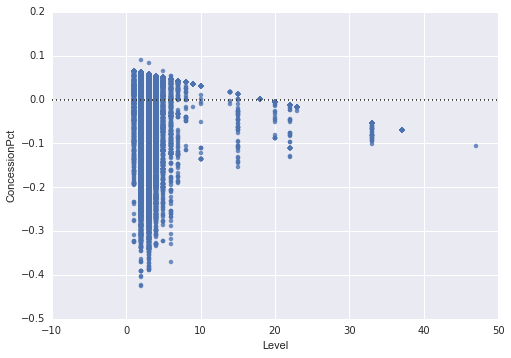

In [104]:
#Plotting residuals of Level vs ConcessionPct
sns.residplot("Level", "ConcessionPct", data=TEST)

###b. Residual Plot for all of the variables in the polynomial regression

##### *Comparison between predicted and actual values

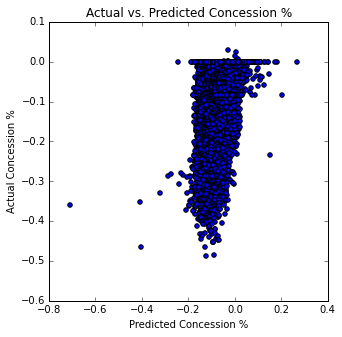

In [105]:
plt.figure(figsize=(5,5))
plt.scatter(predictors, y)
plt.title("Actual vs. Predicted Concession %")
plt.xlabel("Predicted Concession %")
plt.ylabel("Actual Concession %")

#Section III. Cleaning the data

###1. Temporal Comparison between predicted vs actual

In [22]:
#creating x and y variables and getting the predicted values from the polynomial regression earlier
#Also creating predicted values for linear regression
X = result[['Quantity', 'Level', 'AreaPerUnit', 'age', 'RenovationAge', 'HomePriceIndex', 'NewSupply', 'YoungAgeGroup', 'LaborForceParticipation',  'UR', 'AskingRentChange', 'YoungAgeGroup_year', 'LaborForceParticipation_year', 'HomePriceIndex_year', 'AskingRentChange_year']]
y = result['Event']
predictors = poly_3.predict(X)
linearpredictors = lm.predict(X)

#Adding the predicted value for poly and linear regression
#Also making sure the values is reversed because actual Concession%'s sign is reversed
TEST['PredictedConcession']=predictors
TEST['LinearPredictedConcession']=linearpredictors

TEST.PredictedConcession=TEST.PredictedConcession*-1
TEST.LinearPredictedConcession=TEST.LinearPredictedConcession*-1

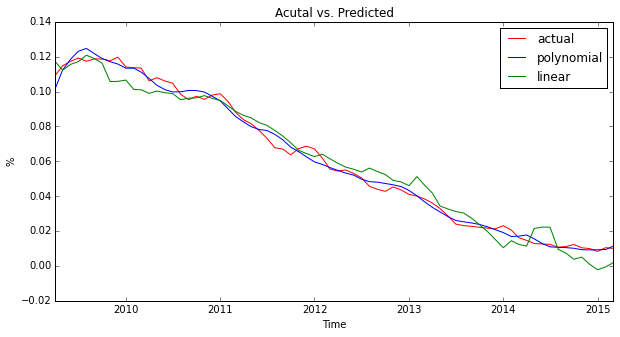

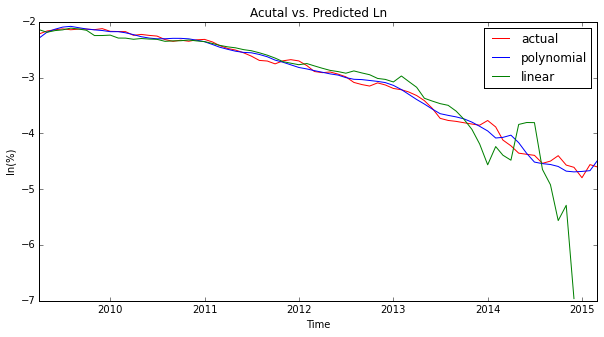

In [243]:
plt.figure(figsize=(10,5))
Timecomparison = TEST.groupby(['Month'], as_index=False).mean()
plt.plot_date(Timecomparison.Month, Timecomparison.ConcessionPct , 'r', label='actual')
plt.plot_date(Timecomparison.Month, Timecomparison.PredictedConcession , 'b', label = 'polynomial')
plt.plot_date(Timecomparison.Month, Timecomparison.LinearPredictedConcession, 'g', label = 'linear')
plt.title('Acutal vs. Predicted')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('%')

plt.figure(figsize=(10,5))
plt.plot_date(Timecomparison.Month, np.log(Timecomparison.ConcessionPct) , 'r', label='actual')
plt.plot_date(Timecomparison.Month, np.log(Timecomparison.PredictedConcession) , 'b', label = 'polynomial')
plt.plot_date(Timecomparison.Month, np.log(Timecomparison.LinearPredictedConcession), 'g', label = 'linear')
plt.title('Acutal vs. Predicted Ln')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('ln(%)')

plt.show()

Things to do:
1. boxplots to show residuals variance
4. include the problem statement, data description, data cleaning process, single factor analysis, distributions
5. Training and Testing: geographically (zip code area)

In [23]:
#Getting the Residuals
TEST['linearresiduals']=TEST.ConcessionPct-TEST.LinearPredictedConcession
TEST['polyresiduals']=TEST.ConcessionPct-TEST.PredictedConcession

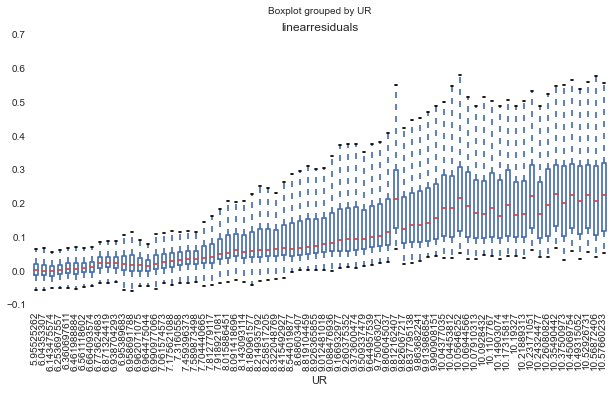

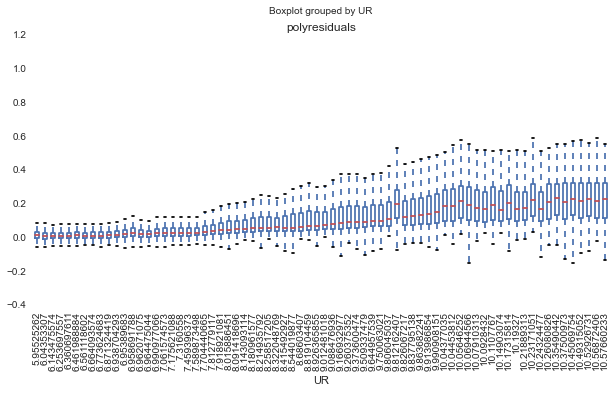

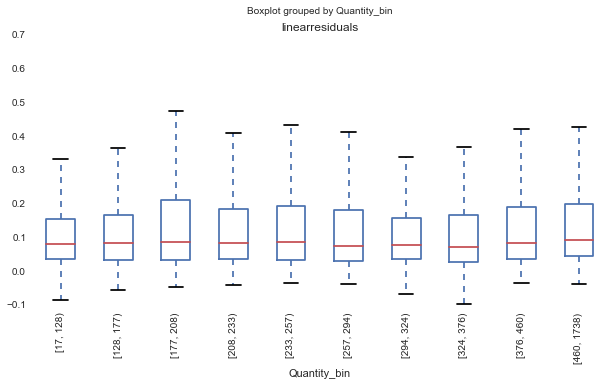

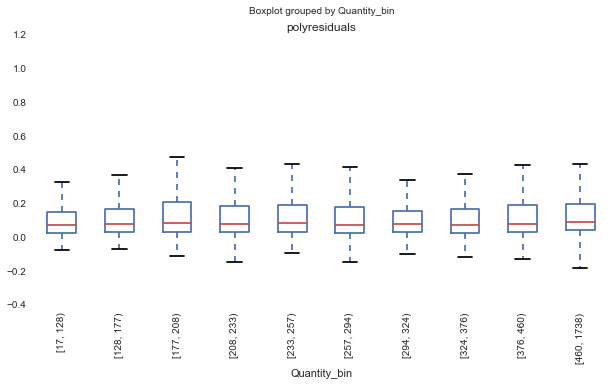

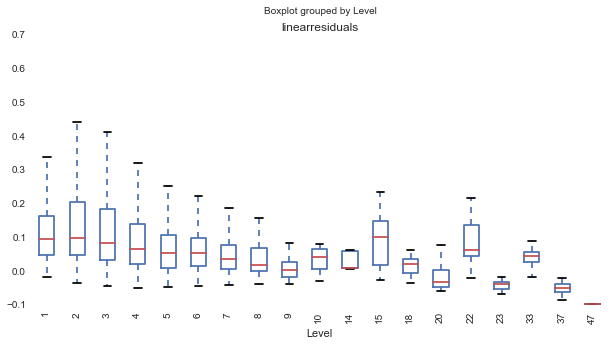

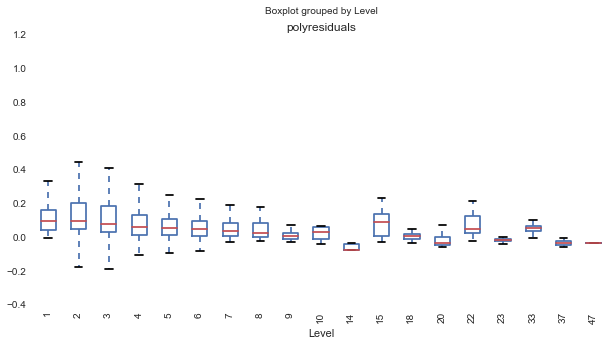

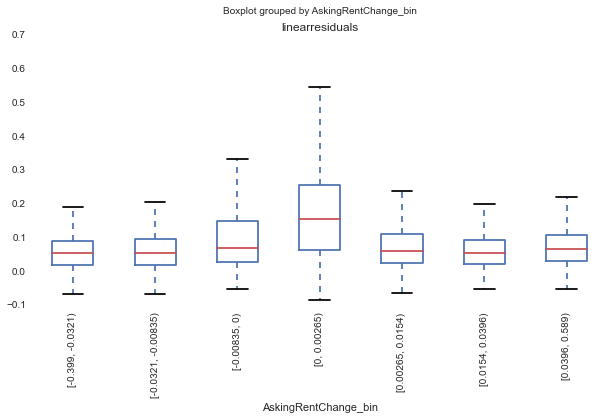

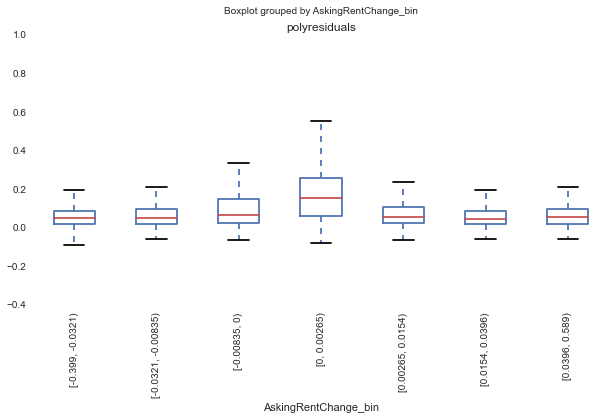

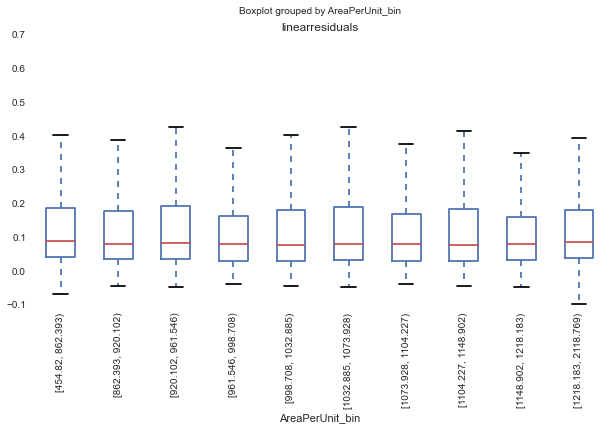

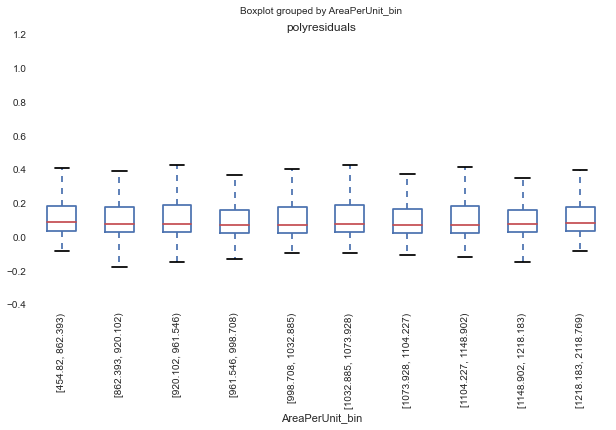

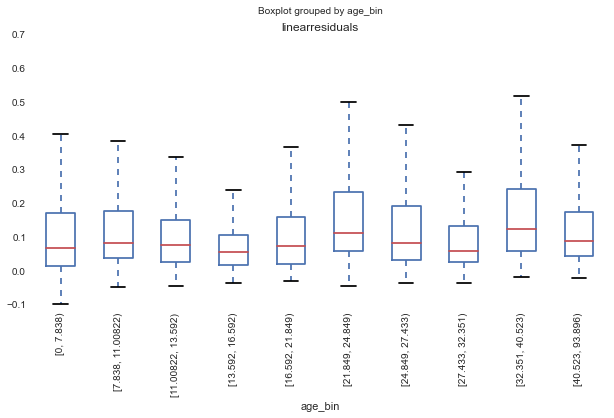

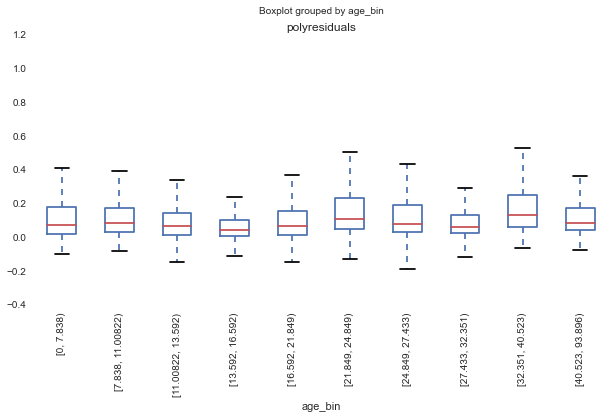

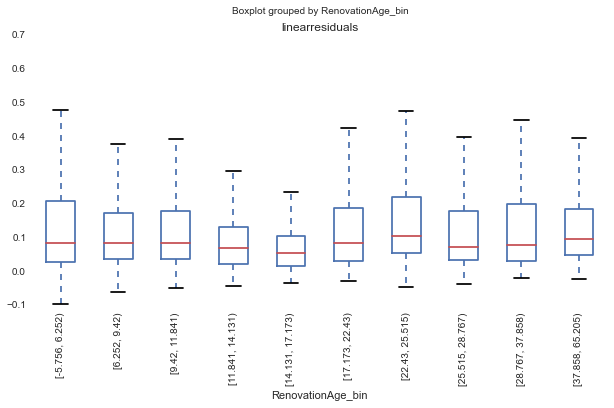

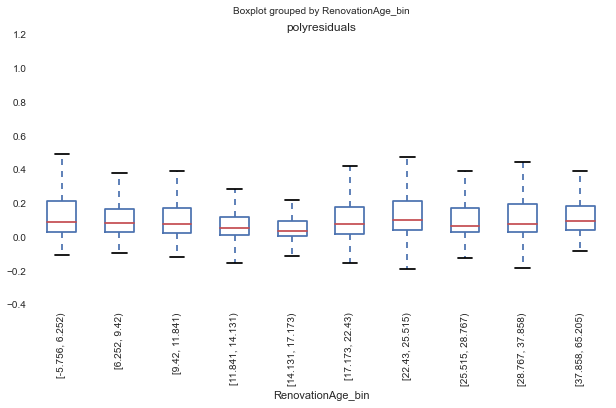

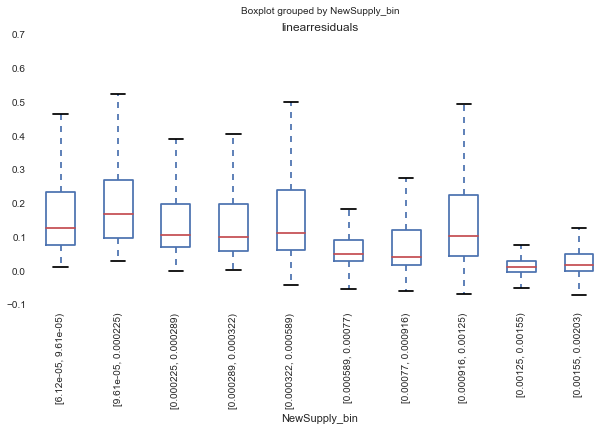

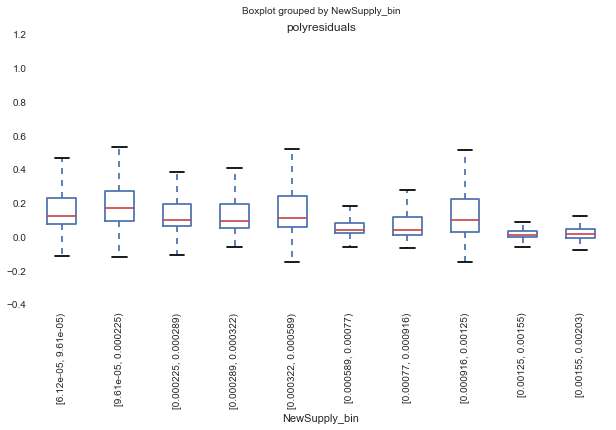

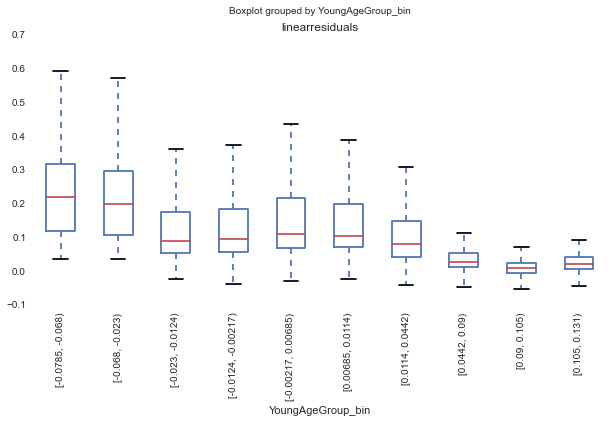

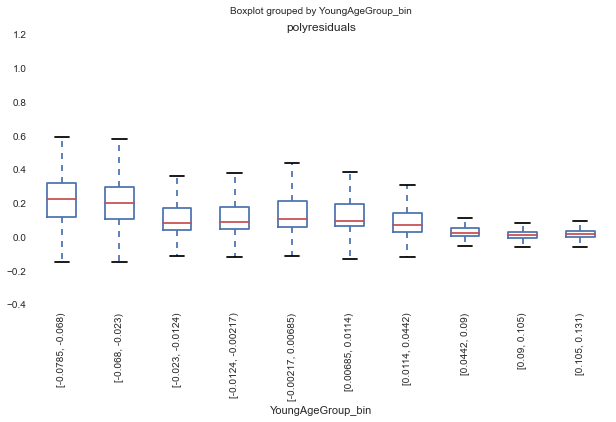

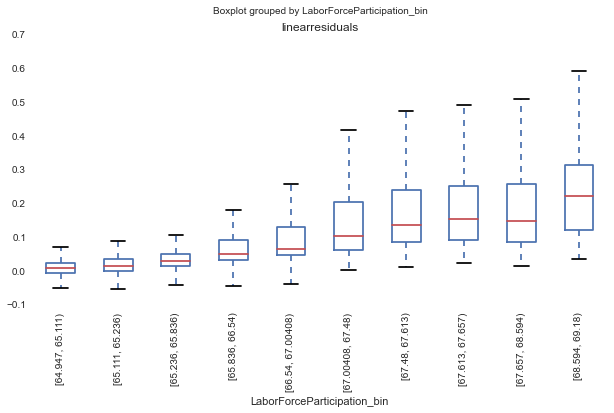

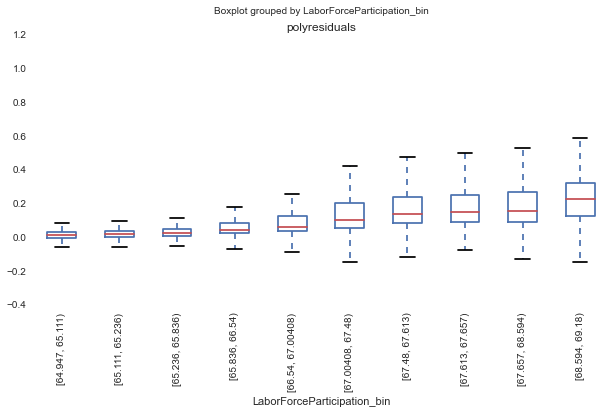

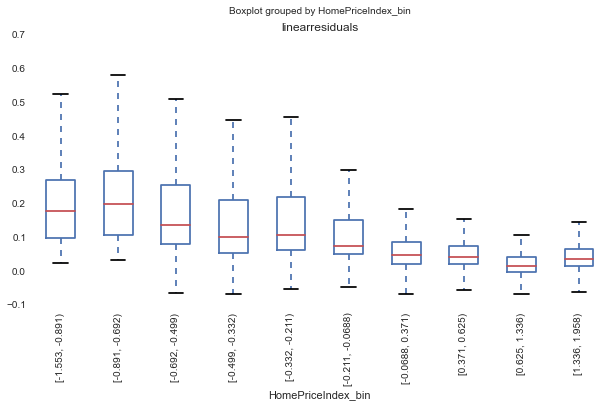

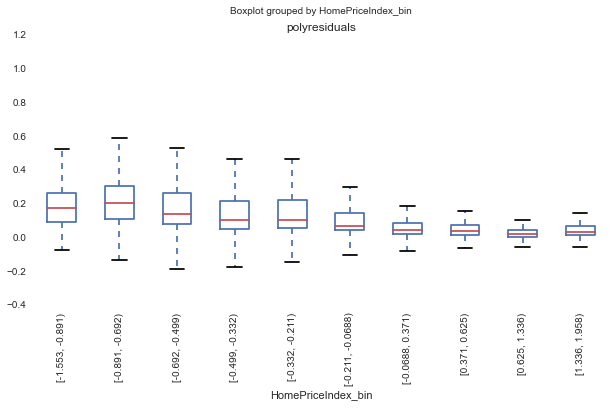

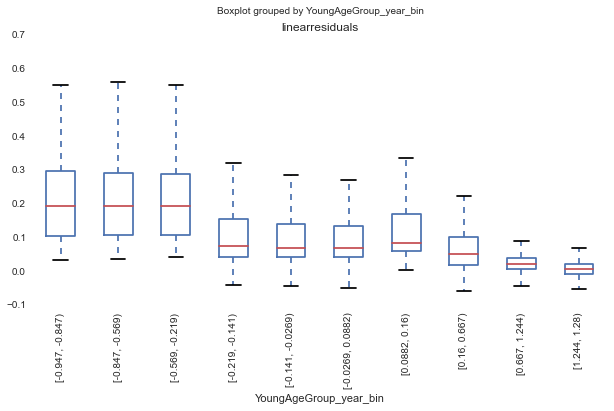

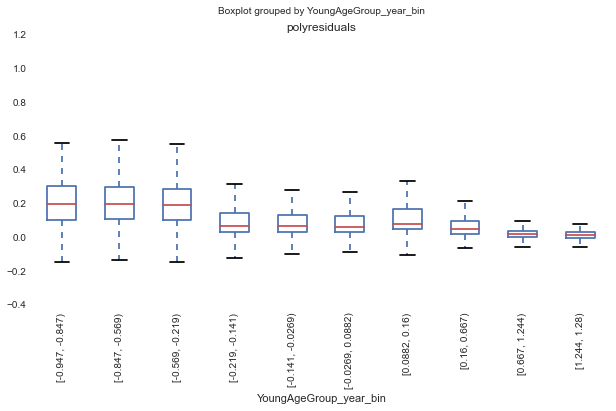

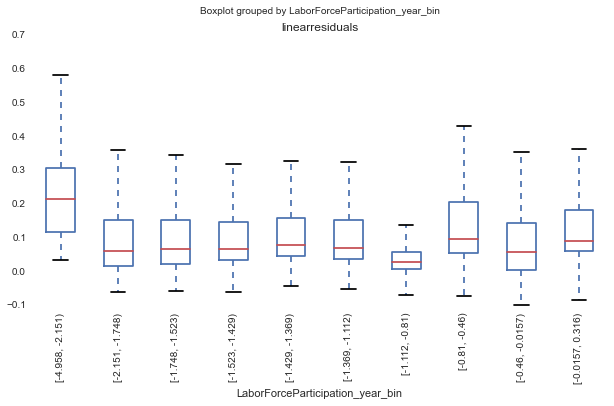

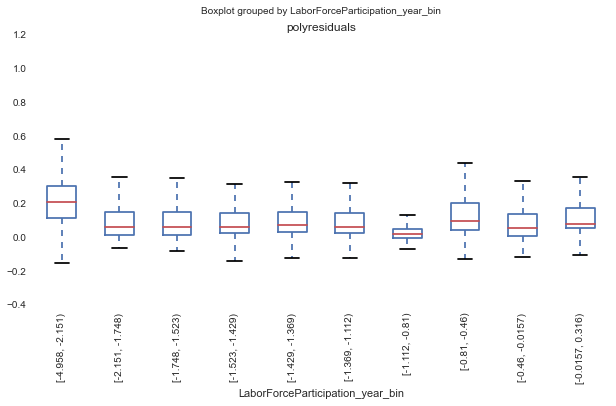

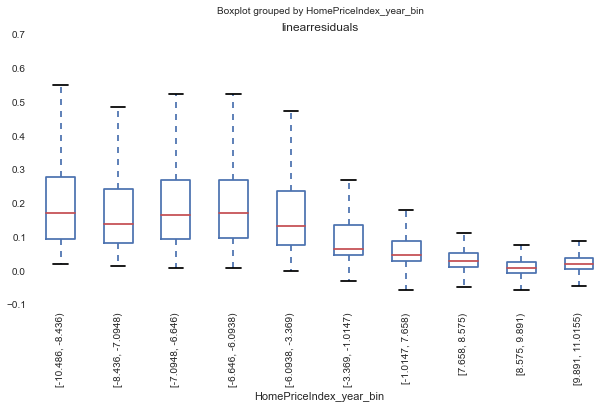

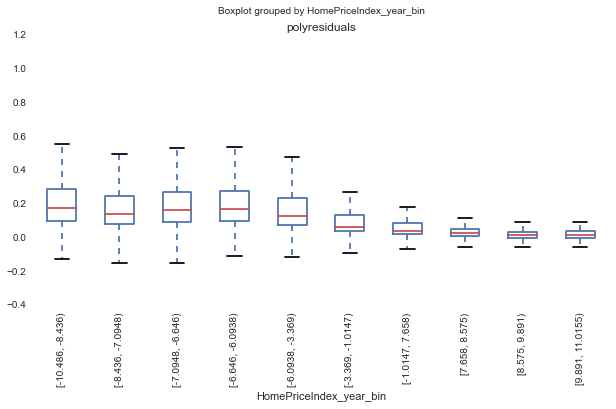

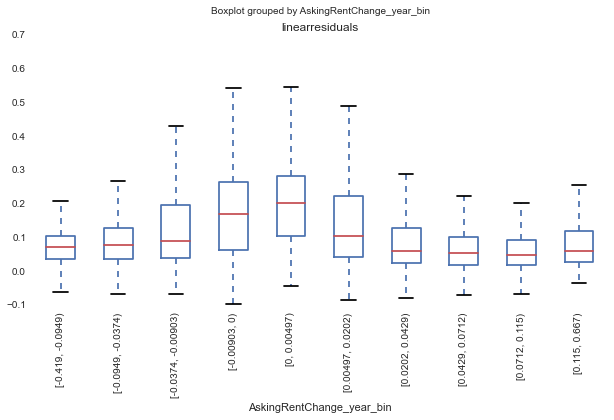

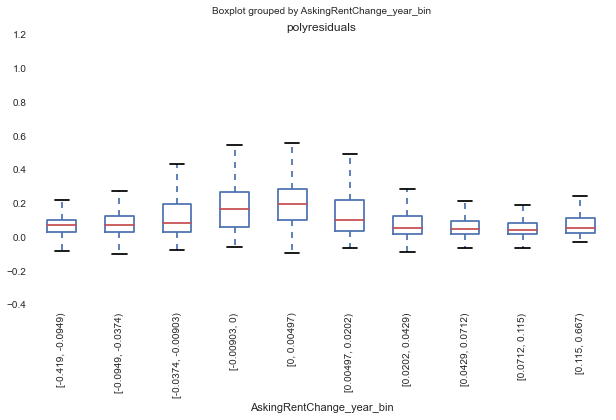

In [123]:
TEST.boxplot('linearresiduals', by = 'UR', rot = 90, figsize=(10,5))
TEST.boxplot('polyresiduals', by = 'UR', rot = 90, figsize=(10,5))

TEST['Quantity_bin']=pd.cut(TEST['Quantity'], bins=sp.stats.mstats.mquantiles(TEST['Quantity'], [0, 1./10, 2./10, 3./10, 4./10, 5./10, 6./10, 7./10, 8./10, 9./10, 1]), right=False)
TEST.boxplot('linearresiduals', by = 'Quantity_bin', rot = 90, figsize=(10,5))
TEST.boxplot('polyresiduals', by = 'Quantity_bin', rot = 90, figsize=(10,5))

TEST.boxplot('linearresiduals', by = 'Level', rot = 90, figsize=(10,5))
TEST.boxplot('polyresiduals', by = 'Level', rot = 90, figsize=(10,5))

binsforaskingrentchange=[]
binsforaskingrentchange=[-0.39938534, -0.03209014, -0.00835497,  0. , 0.00264653, 0.01535915,  0.03957881, 0.58906631]
TEST['AskingRentChange_bin']=pd.cut(TEST['AskingRentChange'], bins=binsforaskingrentchange, right=False)
TEST.boxplot('linearresiduals', by = 'AskingRentChange_bin', rot = 90, figsize=(10,5))
TEST.boxplot('polyresiduals', by = 'AskingRentChange_bin', rot = 90, figsize=(10,5))

TEST['AreaPerUnit_bin']=pd.cut(TEST['AreaPerUnit'], bins=sp.stats.mstats.mquantiles(TEST['AreaPerUnit'], [0, 1./10, 2./10, 3./10, 4./10, 5./10, 6./10, 7./10, 8./10, 9./10, 1]), right=False)
TEST.boxplot('linearresiduals', by = 'AreaPerUnit_bin', rot = 90, figsize=(10,5))
TEST.boxplot('polyresiduals', by = 'AreaPerUnit_bin', rot = 90, figsize=(10,5))

TEST['age_bin']=pd.cut(TEST['age'], bins=sp.stats.mstats.mquantiles(TEST['age'], [0, 1./10, 2./10, 3./10, 4./10, 5./10, 6./10, 7./10, 8./10, 9./10, 1]), right=False)
TEST.boxplot('linearresiduals', by = 'age_bin', rot = 90, figsize=(10,5))
TEST.boxplot('polyresiduals', by = 'age_bin', rot = 90, figsize=(10,5))

TEST['RenovationAge_bin']=pd.cut(TEST['RenovationAge'], bins=sp.stats.mstats.mquantiles(TEST['RenovationAge'], [0, 1./10, 2./10, 3./10, 4./10, 5./10, 6./10, 7./10, 8./10, 9./10, 1]), right=False)
TEST.boxplot('linearresiduals', by = 'RenovationAge_bin', rot = 90, figsize=(10,5))
TEST.boxplot('polyresiduals', by = 'RenovationAge_bin', rot = 90, figsize=(10,5))

TEST['NewSupply_bin']=pd.cut(TEST['NewSupply'], bins=sp.stats.mstats.mquantiles(TEST['NewSupply'], [0, 1./10, 2./10, 3./10, 4./10, 5./10, 6./10, 7./10, 8./10, 9./10, 1]), right=False)
TEST.boxplot('linearresiduals', by = 'NewSupply_bin', rot = 90, figsize=(10,5))
TEST.boxplot('polyresiduals', by = 'NewSupply_bin', rot = 90, figsize=(10,5))

TEST['YoungAgeGroup_bin']=pd.cut(TEST['YoungAgeGroup'], bins=sp.stats.mstats.mquantiles(TEST['YoungAgeGroup'], [0, 1./10, 2./10, 3./10, 4./10, 5./10, 6./10, 7./10, 8./10, 9./10, 1]), right=False)
TEST.boxplot('linearresiduals', by = 'YoungAgeGroup_bin', rot = 90, figsize=(10,5))
TEST.boxplot('polyresiduals', by = 'YoungAgeGroup_bin', rot = 90, figsize=(10,5))

TEST['LaborForceParticipation_bin']=pd.cut(TEST['LaborForceParticipation'], bins=sp.stats.mstats.mquantiles(TEST['LaborForceParticipation'], [0, 1./10, 2./10, 3./10, 4./10, 5./10, 6./10, 7./10, 8./10, 9./10, 1]), right=False)
TEST.boxplot('linearresiduals', by = 'LaborForceParticipation_bin', rot = 90, figsize=(10,5))
TEST.boxplot('polyresiduals', by = 'LaborForceParticipation_bin', rot = 90, figsize=(10,5))

TEST['HomePriceIndex_bin']=pd.cut(TEST['HomePriceIndex'], bins=sp.stats.mstats.mquantiles(TEST['HomePriceIndex'], [0, 1./10, 2./10, 3./10, 4./10, 5./10, 6./10, 7./10, 8./10, 9./10, 1]), right=False)
TEST.boxplot('linearresiduals', by = 'HomePriceIndex_bin', rot = 90, figsize=(10,5))
TEST.boxplot('polyresiduals', by = 'HomePriceIndex_bin', rot = 90, figsize=(10,5))

TEST['YoungAgeGroup_year_bin']=pd.cut(TEST['YoungAgeGroup_year'], bins=sp.stats.mstats.mquantiles(TEST['YoungAgeGroup_year'], [0, 1./10, 2./10, 3./10, 4./10, 5./10, 6./10, 7./10, 8./10, 9./10, 1]), right=False)
TEST.boxplot('linearresiduals', by = 'YoungAgeGroup_year_bin', rot = 90, figsize=(10,5))
TEST.boxplot('polyresiduals', by = 'YoungAgeGroup_year_bin', rot = 90, figsize=(10,5))

TEST['LaborForceParticipation_year_bin']=pd.cut(TEST['LaborForceParticipation_year'], bins=sp.stats.mstats.mquantiles(TEST['LaborForceParticipation_year'], [0, 1./10, 2./10, 3./10, 4./10, 5./10, 6./10, 7./10, 8./10, 9./10, 1]), right=False)
TEST.boxplot('linearresiduals', by = 'LaborForceParticipation_year_bin', rot = 90, figsize=(10,5))
TEST.boxplot('polyresiduals', by = 'LaborForceParticipation_year_bin', rot = 90, figsize=(10,5))

TEST['HomePriceIndex_year_bin']=pd.cut(TEST['HomePriceIndex_year'], bins=sp.stats.mstats.mquantiles(TEST['HomePriceIndex_year'], [0, 1./10, 2./10, 3./10, 4./10, 5./10, 6./10, 7./10, 8./10, 9./10, 1]), right=False)
TEST.boxplot('linearresiduals', by = 'HomePriceIndex_year_bin', rot = 90, figsize=(10,5))
TEST.boxplot('polyresiduals', by = 'HomePriceIndex_year_bin', rot = 90, figsize=(10,5))

TEST['AskingRentChange_year_bin']=pd.cut(TEST['AskingRentChange_year'], bins=sp.stats.mstats.mquantiles(TEST['AskingRentChange_year'], [0, 1./10, 2./10, 3./10, 4./10, 5./10, 6./10, 7./10, 8./10, 9./10, 1]), right=False)
TEST.boxplot('linearresiduals', by = 'AskingRentChange_year_bin', rot = 90, figsize=(10,5))
TEST.boxplot('polyresiduals', by = 'AskingRentChange_year_bin', rot = 90, figsize=(10,5))

###2. Comparing Actual vs. Predicted per variable

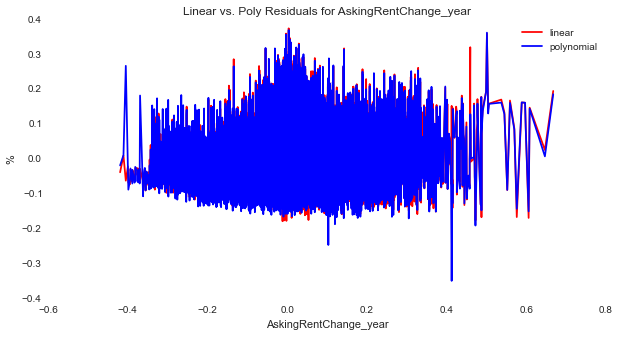

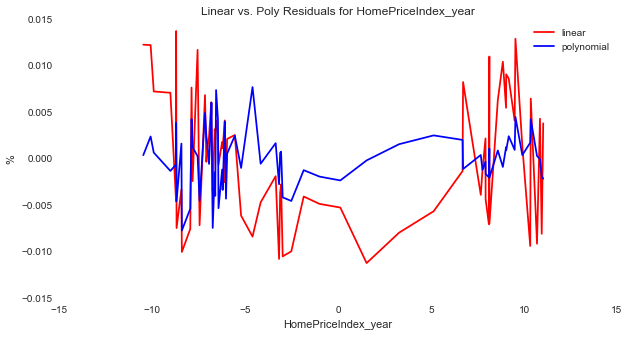

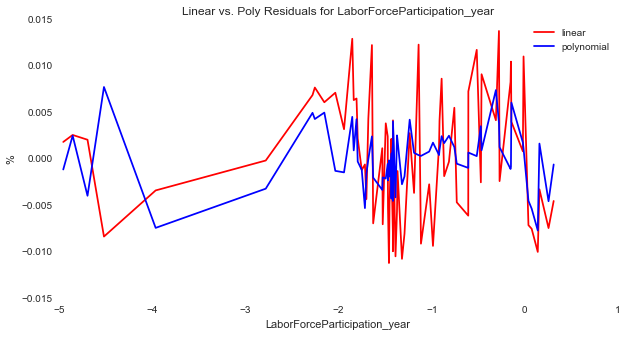

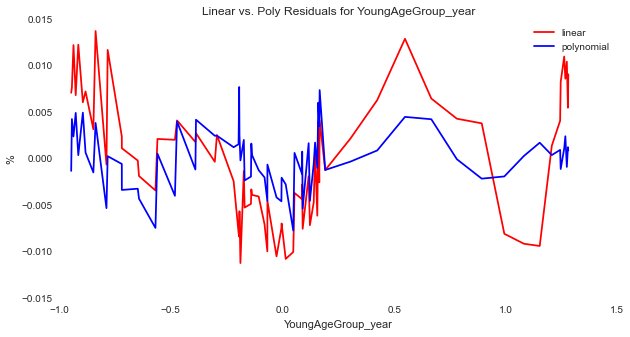

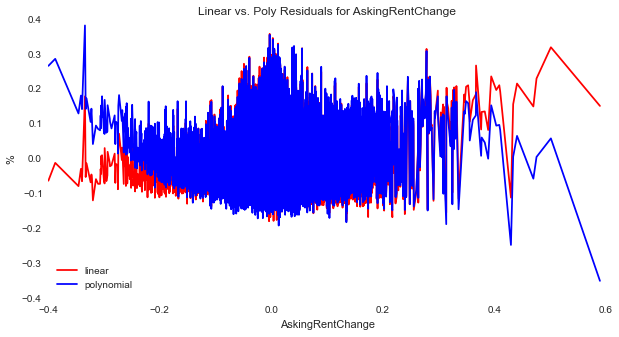

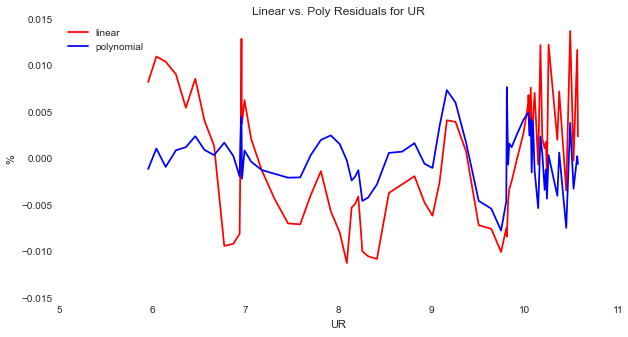

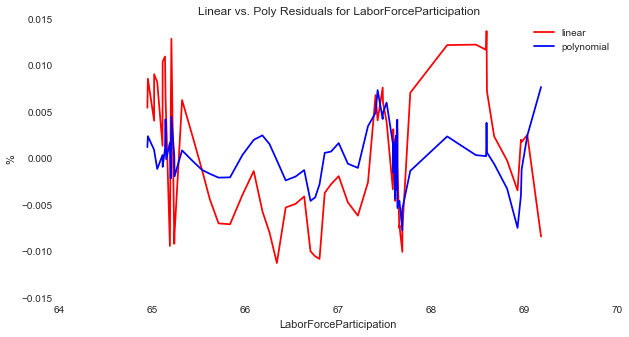

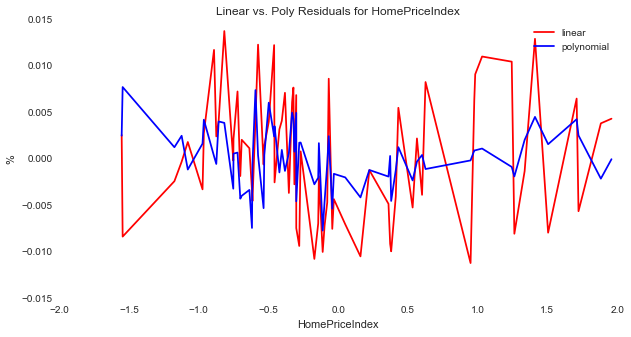

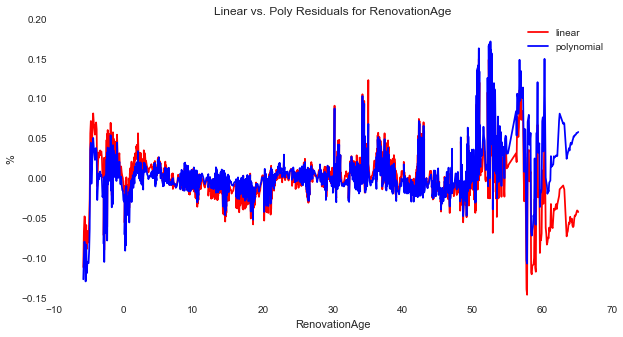

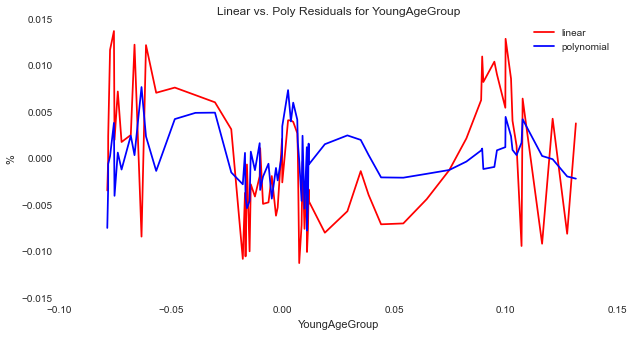

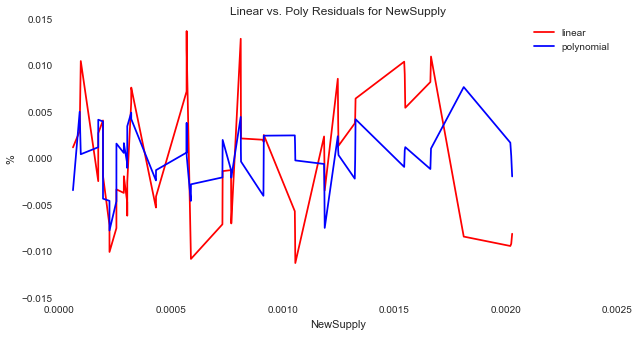

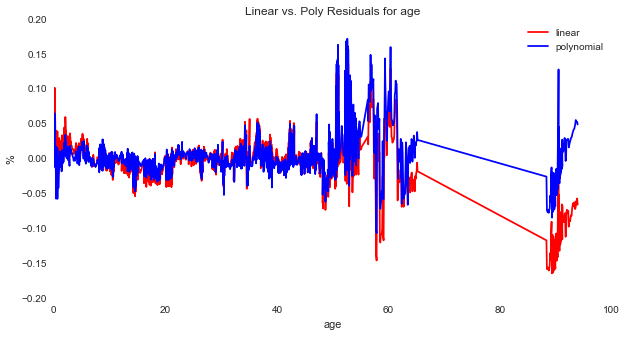

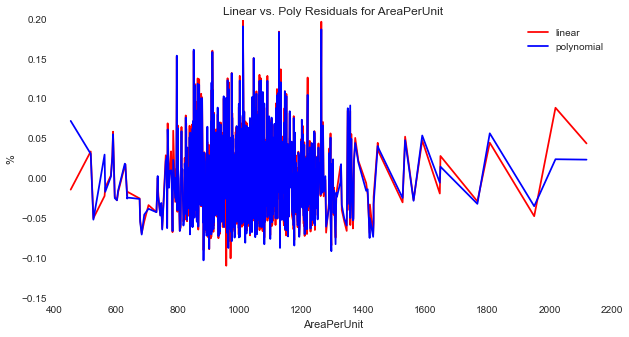

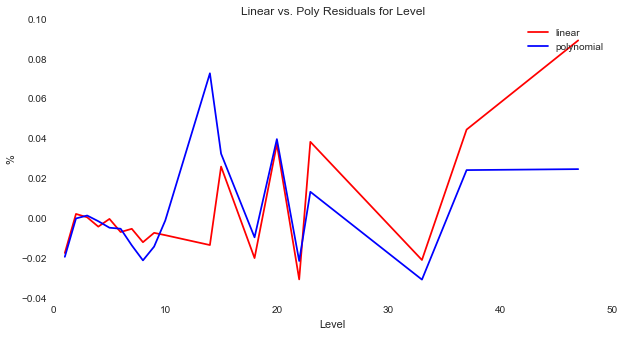

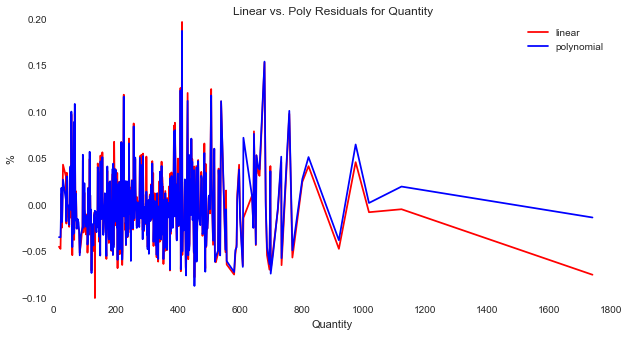

In [53]:
#After taking average by the variable value itself, graphing the actual vs. linear predicted vs. polynomial predicted
AskingRentChange_yearcomparison = TEST.groupby(['AskingRentChange_year'], as_index=False).mean()
plt.figure(figsize=(10,5))
plt.plot(AskingRentChange_yearcomparison.AskingRentChange_year, AskingRentChange_yearcomparison.linearresiduals , 'r', label='linear')
plt.plot(AskingRentChange_yearcomparison.AskingRentChange_year, AskingRentChange_yearcomparison.polyresiduals , 'b', label = 'polynomial')
plt.title('Linear vs. Poly Residuals for AskingRentChange_year')
plt.legend(loc='best')
plt.xlabel('AskingRentChange_year')
plt.ylabel('%')

HomePriceIndex_yearcomparison = TEST.groupby(['HomePriceIndex_year'], as_index=False).mean()
plt.figure(figsize=(10,5))
plt.plot(HomePriceIndex_yearcomparison.HomePriceIndex_year, HomePriceIndex_yearcomparison.linearresiduals , 'r', label='linear')
plt.plot(HomePriceIndex_yearcomparison.HomePriceIndex_year, HomePriceIndex_yearcomparison.polyresiduals , 'b', label = 'polynomial')
plt.title('Linear vs. Poly Residuals for HomePriceIndex_year')
plt.legend(loc='best')
plt.xlabel('HomePriceIndex_year')
plt.ylabel('%')

LaborForceParticipation_yearcomparison = TEST.groupby(['LaborForceParticipation_year'], as_index=False).mean()
plt.figure(figsize=(10,5))
plt.plot(LaborForceParticipation_yearcomparison.LaborForceParticipation_year, LaborForceParticipation_yearcomparison.linearresiduals , 'r', label='linear')
plt.plot(LaborForceParticipation_yearcomparison.LaborForceParticipation_year, LaborForceParticipation_yearcomparison.polyresiduals , 'b', label = 'polynomial')
plt.title('Linear vs. Poly Residuals for LaborForceParticipation_year')
plt.legend(loc='best')
plt.xlabel('LaborForceParticipation_year')
plt.ylabel('%')

YoungAgeGroup_yearcomparison = TEST.groupby(['YoungAgeGroup_year'], as_index=False).mean()
plt.figure(figsize=(10,5))
plt.plot(YoungAgeGroup_yearcomparison.YoungAgeGroup_year, YoungAgeGroup_yearcomparison.linearresiduals , 'r', label='linear')
plt.plot(YoungAgeGroup_yearcomparison.YoungAgeGroup_year, YoungAgeGroup_yearcomparison.polyresiduals , 'b', label = 'polynomial')
plt.title('Linear vs. Poly Residuals for YoungAgeGroup_year')
plt.legend(loc='best')
plt.xlabel('YoungAgeGroup_year')
plt.ylabel('%')

AskingRentChangecomparison = TEST.groupby(['AskingRentChange'], as_index=False).mean()
plt.figure(figsize=(10,5))
plt.plot(AskingRentChangecomparison.AskingRentChange, AskingRentChangecomparison.linearresiduals , 'r', label='linear')
plt.plot(AskingRentChangecomparison.AskingRentChange, AskingRentChangecomparison.polyresiduals , 'b', label = 'polynomial')
plt.title('Linear vs. Poly Residuals for AskingRentChange')
plt.legend(loc='best')
plt.xlabel('AskingRentChange')
plt.ylabel('%')

URcomparison = TEST.groupby(['UR'], as_index=False).mean()
plt.figure(figsize=(10,5))
plt.plot(URcomparison.UR, URcomparison.linearresiduals , 'r', label='linear')
plt.plot(URcomparison.UR, URcomparison.polyresiduals , 'b', label = 'polynomial')
plt.title('Linear vs. Poly Residuals for UR')
plt.legend(loc='best')
plt.xlabel('UR')
plt.ylabel('%')

LaborForceParticipationcomparison = TEST.groupby(['LaborForceParticipation'], as_index=False).mean()
plt.figure(figsize=(10,5))
plt.plot(LaborForceParticipationcomparison.LaborForceParticipation, LaborForceParticipationcomparison.linearresiduals , 'r', label='linear')
plt.plot(LaborForceParticipationcomparison.LaborForceParticipation, LaborForceParticipationcomparison.polyresiduals , 'b', label = 'polynomial')
plt.title('Linear vs. Poly Residuals for LaborForceParticipation')
plt.legend(loc='best')
plt.xlabel('LaborForceParticipation')
plt.ylabel('%')

HomePriceIndexcomparison = TEST.groupby(['HomePriceIndex'], as_index=False).mean()
plt.figure(figsize=(10,5))
plt.plot(HomePriceIndexcomparison.HomePriceIndex, HomePriceIndexcomparison.linearresiduals , 'r', label='linear')
plt.plot(HomePriceIndexcomparison.HomePriceIndex, HomePriceIndexcomparison.polyresiduals , 'b', label = 'polynomial')
plt.title('Linear vs. Poly Residuals for HomePriceIndex')
plt.legend()
plt.xlabel('HomePriceIndex')
plt.ylabel('%')

RenovationAgecomparison = TEST.groupby(['RenovationAge'], as_index=False).mean()
plt.figure(figsize=(10,5))
plt.plot(RenovationAgecomparison.RenovationAge, RenovationAgecomparison.linearresiduals , 'r', label='linear')
plt.plot(RenovationAgecomparison.RenovationAge, RenovationAgecomparison.polyresiduals , 'b', label = 'polynomial')
plt.title('Linear vs. Poly Residuals for RenovationAge')
plt.legend(loc='best')
plt.xlabel('RenovationAge')
plt.ylabel('%')

YoungAgeGroupcomparison = TEST.groupby(['YoungAgeGroup'], as_index=False).mean()
plt.figure(figsize=(10,5))
plt.plot(YoungAgeGroupcomparison.YoungAgeGroup, YoungAgeGroupcomparison.linearresiduals , 'r', label='linear')
plt.plot(YoungAgeGroupcomparison.YoungAgeGroup, YoungAgeGroupcomparison.polyresiduals , 'b', label = 'polynomial')
plt.title('Linear vs. Poly Residuals for YoungAgeGroup')
plt.legend()
plt.xlabel('YoungAgeGroup')
plt.ylabel('%')

newsupplycomparison = TEST.groupby(['NewSupply'], as_index=False).mean()
plt.figure(figsize=(10,5))
plt.plot(newsupplycomparison.NewSupply, newsupplycomparison.linearresiduals , 'r', label='linear')
plt.plot(newsupplycomparison.NewSupply, newsupplycomparison.polyresiduals , 'b', label = 'polynomial')
plt.title('Linear vs. Poly Residuals for NewSupply')
plt.legend()
plt.xlabel('NewSupply')
plt.ylabel('%')

agecomparison = TEST.groupby(['age'], as_index=False).mean()
plt.figure(figsize=(10,5))
plt.plot(agecomparison.age, agecomparison.linearresiduals , 'r', label='linear')
plt.plot(agecomparison.age, agecomparison.polyresiduals , 'b', label = 'polynomial')
plt.title('Linear vs. Poly Residuals for age')
plt.legend()
plt.xlabel('age')
plt.ylabel('%')

areacomparison = TEST.groupby(['AreaPerUnit'], as_index=False).mean()
plt.figure(figsize=(10,5))
plt.plot(areacomparison.AreaPerUnit, areacomparison.linearresiduals , 'r', label='linear')
plt.plot(areacomparison.AreaPerUnit, areacomparison.polyresiduals , 'b', label = 'polynomial')
plt.title('Linear vs. Poly Residuals for AreaPerUnit')
plt.legend()
plt.xlabel('AreaPerUnit')
plt.ylabel('%')

levelcomparison = TEST.groupby(['Level'], as_index=False).mean()
plt.figure(figsize=(10,5))
plt.plot(levelcomparison.Level, levelcomparison.linearresiduals , 'r', label='linear')
plt.plot(levelcomparison.Level, levelcomparison.polyresiduals , 'b', label = 'polynomial')
plt.title('Linear vs. Poly Residuals for Level')
plt.legend()
plt.xlabel('Level')
plt.ylabel('%')

quantitycomparison = TEST.groupby(['Quantity'], as_index=False).mean()
plt.figure(figsize=(10,5))
plt.plot(quantitycomparison.Quantity, quantitycomparison.linearresiduals , 'r', label='linear')
plt.plot(quantitycomparison.Quantity, quantitycomparison.polyresiduals , 'b', label = 'polynomial')
plt.title('Linear vs. Poly Residuals for Quantity')
plt.legend()
plt.xlabel('Quantity')
plt.ylabel('%')
plt.show()

###3. Checking the distributions for the variables

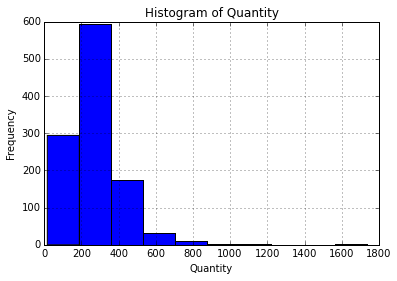

In [66]:
atlanta.Quantity.hist()
plt.title('Histogram of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')

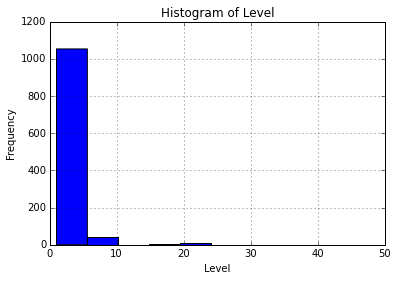

In [67]:
atlanta.Level.hist()
plt.title('Histogram of Level')
plt.xlabel('Level')
plt.ylabel('Frequency')

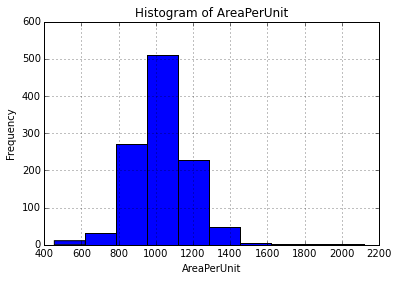

In [68]:
atlanta.AreaPerUnit.hist()
plt.title('Histogram of AreaPerUnit')
plt.xlabel('AreaPerUnit')
plt.ylabel('Frequency')

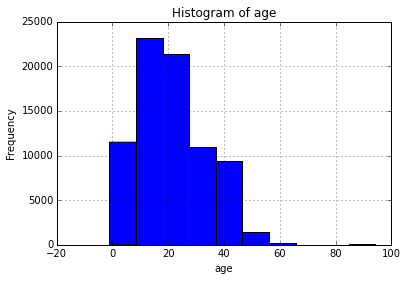

In [65]:
finaldata.age.hist()
plt.title('Histogram of age')
plt.xlabel('age')
plt.ylabel('Frequency')

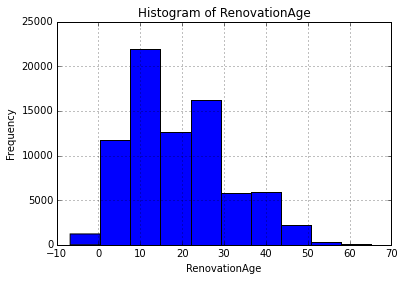

In [69]:
finaldata.RenovationAge.hist()
plt.title('Histogram of RenovationAge')
plt.xlabel('RenovationAge')
plt.ylabel('Frequency')

##4. Training and Testing the polynomial regression

#####a. The regular way of dividing

In [63]:
TESTcopied=TEST.copy(deep=True)

TESTcopied['Event']=0
TEST['Event']=1

TESTcopied['Weight']=(1000*(1-TESTcopied.ConcessionPct)).astype(int)
TEST['Weight']=(1000*(TESTcopied.ConcessionPct)).astype(int)

frames=[TEST, TESTcopied]
result = pd.concat(frames)

#Placing the polynomial regression into a matrix for learning from the data=result
y, X = dmatrices('Event ~ Quantity + I(Quantity ** 2.0) + I(Quantity ** 3) + Level +I(Level ** 2.0)+ AreaPerUnit + age+I(age ** 2.0)+I(age ** 3.0) + RenovationAge+I(RenovationAge ** 2.0) +I(RenovationAge ** 3.0) + NewSupply + YoungAgeGroup + I(YoungAgeGroup ** 2.0) + LaborForceParticipation + UR + I(UR ** 2)+ AskingRentChange +I(AskingRentChange ** 2.0) + +I(AskingRentChange ** 3.0)+YoungAgeGroup_year+LaborForceParticipation_year+HomePriceIndex_year+ AskingRentChange_year', result, 
                  return_type="dataframe")
#flatten y into a 1-D array, so that scikit-learn will properly understand it as the response variable.
y = np.ravel(y)
#run logistic regression on the entire data set, and see how accurate it is!
clf = linear_model.SGDClassifier(loss="log")
clf = clf.fit(X, y, class_weight = result.Weight)

#try putting logistics regression on there to see the difference
# check the accuracy on the training set
clf.score(X, y)

#The null error rate or the average concession rate
y.mean()

In [136]:
#examine the coefficients
pd.DataFrame(zip(X.columns, np.transpose(clf.coef_)))

,0,1
0,Intercept,[-0.00783577469954]
1,Quantity,[-1.81789973029]
2,I(Quantity ** 2.0),[-421.752737428]
3,I(Quantity ** 3),[-97846.6350833]
4,Level,[-0.0235073240986]
5,I(Level ** 2.0),[-0.0705219722958]
6,AreaPerUnit,[-7.13886359954]
7,age,[-0.190119508885]
8,I(age ** 2.0),[-4.61287224871]
9,I(age ** 3.0),[-111.922182567]


####b. Split into two sets (train and test) first

In [203]:
#splitting into 2 datasets here
asdfasdf = random.sample(TEST.index, 20000)
TRAIN_20000 = TEST.drop(asdfasdf)
TEST_20000 = TEST.ix[asdfasdf]

In [204]:
#assigning event 1 or 0
TRAIN_20000copied=TRAIN_20000.copy(deep=True)
TRAIN_20000copied['Event']=0
TRAIN_20000['Event']=1

#assigning weight accordingly
TRAIN_20000copied['Weight']=(1000*(1-TRAIN_20000copied.ConcessionPct)).astype(int)
TRAIN_20000['Weight']=(1000*(TRAIN_20000.ConcessionPct)).astype(int)

#adding the two dataframes together
trainframes=[TRAIN_20000, TRAIN_20000copied]
trainresult = pd.concat(trainframes)
#####################################
#assigning event 1 or 0
TEST_20000copied=TEST_20000.copy(deep=True)
TEST_20000copied['Event']=0
TEST_20000['Event']=1

#assigning weight accordingly
TEST_20000copied['Weight']=(1000*(1-TEST_20000copied.ConcessionPct)).astype(int)
TEST_20000['Weight']=(1000*(TEST_20000.ConcessionPct)).astype(int)

#adding the two dataframes together
testframes=[TEST_20000, TEST_20000copied]
testresult = pd.concat(testframes)

In [265]:
trainy, trainX = dmatrices('Event ~ Quantity + I(Quantity ** 2.0) + I(Quantity ** 3) + Level +I(Level ** 2.0)+ AreaPerUnit + age+I(age ** 2.0)+I(age ** 3.0) + RenovationAge+I(RenovationAge ** 2.0) +I(RenovationAge ** 3.0) + NewSupply + YoungAgeGroup + I(YoungAgeGroup ** 2.0) + LaborForceParticipation + UR + I(UR ** 2)+ AskingRentChange +I(AskingRentChange ** 2.0) + +I(AskingRentChange ** 3.0)+YoungAgeGroup_year+LaborForceParticipation_year+HomePriceIndex_year+ AskingRentChange_year', trainresult, 
                  return_type="dataframe")
trainy = np.ravel(trainy)
dlf = linear_model.SGDClassifier(loss="log")
dlf = dlf.fit(trainX, trainy, sample_weight = trainresult.Weight)

dlf.score(trainX, trainy)
trainy.mean()
pd.DataFrame(zip(trainX.columns, np.transpose(dlf.coef_)))

,0,1
0,Intercept,[-28.1785623797]
1,Quantity,[-6915.058012]
2,I(Quantity ** 2.0),[-1390879.77831]
3,I(Quantity ** 3),[-219754133.016]
4,Level,[-111.744149153]
5,I(Level ** 2.0),[-389.649371489]
6,AreaPerUnit,[-20769.2035406]
7,age,[-600.513795297]
8,I(age ** 2.0),[-9609.72397928]
9,I(age ** 3.0),[-374.29753496]


In [266]:
dlf

SGDClassifier(alpha=0.0001, class_weight=None, epsilon=0.1, eta0=0.0,
       fit_intercept=True, l1_ratio=0.15, learning_rate='optimal',
       loss='log', n_iter=5, n_jobs=1, penalty='l2', power_t=0.5,
       random_state=None, shuffle=False, verbose=0, warm_start=False)

In [130]:
#Model Evaluation Using a Validation Set
#So far, we have trained and tested on the same set. 
#Let's instead split the data "randomly" into a training set and a testing set.
#Evaluate the model by splitting into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
#here, you feed in 30% of your data into training: x_train into y_train
#clf.fit(X_train, y_train, class_weight = result.Weight)

SGDClassifier(alpha=0.0001, class_weight=None, epsilon=0.1, eta0=0.0,
       fit_intercept=True, l1_ratio=0.15, learning_rate='optimal',
       loss='log', n_iter=5, n_jobs=1, penalty='l2', power_t=0.5,
       random_state=None, shuffle=False, verbose=0, warm_start=False)

In [238]:
trainresult.Weight

0     147
2      91
3     202
4      67
5       0
6     231
7     184
8      39
9      83
12    249
13    158
14    256
16      0
20     27
21    125
...
65058    1000
65059     999
65060    1000
65061    1000
65062     930
65064    1000
65065    1000
65066     976
65071    1000
65072     958
65075    1000
65077     973
65081     970
65082    1000
65083    1000
Name: Weight, Length: 87420, dtype: int32

In [235]:
y_test.mean()

Event    0.5
dtype: float64

In [220]:
y_test, X_test = dmatrices('Event ~ Quantity + I(Quantity ** 2.0) + I(Quantity ** 3) + Level +I(Level ** 2.0)+ AreaPerUnit + age+I(age ** 2.0)+I(age ** 3.0) + RenovationAge+I(RenovationAge ** 2.0) +I(RenovationAge ** 3.0) + NewSupply + YoungAgeGroup + I(YoungAgeGroup ** 2.0) + LaborForceParticipation + UR + I(UR ** 2)+ AskingRentChange +I(AskingRentChange ** 2.0) + +I(AskingRentChange ** 3.0)+YoungAgeGroup_year+LaborForceParticipation_year+HomePriceIndex_year+ AskingRentChange_year', testresult, 
                  return_type="dataframe")

In [264]:
predicted=dlf.predict(X_test)
np.set_printoptions(precision=3)
print(predicted)

[ 0.  0.  0. ...,  0.  0.  0.]


In [248]:
#Predict concession% from the variables for the test set. 
predicted = dlf.predict(X_test)
print predicted

[ 0.  0.  0. ...,  0.  0.  0.]


In [262]:
# generate class probabilities
probs = dlf.predict_proba(X_test)
np.set_printoptions(precision=3)
print probs

[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 ..., 
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]


The classifier is predicting a 0 (no Concession) any time the probability in the second column is 0.

In [223]:
# generate evaluation metrics
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs[:, 1])

0.5
0.5


The accuracy is 50%, which is the same as we experienced when training and predicting on the same data.

By definition a confusion matrix C is such that $C_{i, j}$ is equal to the number of observations known to be in group i but predicted to be in group j.

In [224]:
#the confusion matrix and a classification report with other metrics.
print metrics.confusion_matrix(y_test, predicted)
print metrics.classification_report(y_test, predicted)

[[20000     0]
 [20000     0]]
             precision    recall  f1-score   support

        0.0       0.50      1.00      0.67     20000
        1.0       0.00      0.00      0.00     20000

avg / total       0.25      0.50      0.33     40000



###5. Model Evaluation Using Cross-Validation
#### 10-fold cross-validation, to see if the accuracy holds up more rigorously.

In [209]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(dlf, X, y, scoring='accuracy', cv=10)
print scores
print scores.mean()

[ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5]
0.5


59% Accuracy Performing

###6.  Predicting the Probability of Concession%
Predicting the probability of concession for a random property not present in the dataset. 

In [ ]:
model.predict_proba(np.array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 3, 25, 3, 1, 4,
                              16]))




Quantity + I(Quantity ** 2.0) + I(Quantity ** 3) + Level +I(Level ** 2.0)+ AreaPerUnit + age+I(age ** 2.0)+I(age ** 3.0) + RenovationAge+I(RenovationAge ** 2.0) +I(RenovationAge ** 3.0) + NewSupply + YoungAgeGroup + I(YoungAgeGroup ** 2.0) + LaborForceParticipation + UR + I(UR ** 2)+ AskingRentChange +I(AskingRentChange ** 2.0) + +I(AskingRentChange ** 3.0)+YoungAgeGroup_year+LaborForceParticipation_year+HomePriceIndex_year+ AskingRentChange_year